
The notebook is about predicting used cars prices based on a provided dataset. In order to achieve this goal, we had to make some basic milestones. The following plan describes the steps we followed in this journey

**I - Data Analysis**
1.   Data Exploration
2.   Outliers Handling
3.   Feature Engeneering
4.   Handeling missing values
5.   Feature selection
6.   Bivariate Analysis

**II  - Modeling**
1. Linear regression models
2. Random forests
3. Xgboost (Extreem Gradient boosting)

**III - Interprtability with SHAP**

In [ ]:
# import all libraries
import pandas as pd 
import numpy as np
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures,scale,OrdinalEncoder
from sklearn.feature_selection import RFE,VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats
import xgboost as xgb
import re
import warnings # supress warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
def barplotsColumns(autos,nLower = 2,nUpper = 100):
    """
    Function to vizualize Barplots with respect to different columns.
    :autos: Dataframe
    :nLower: Lower bound of variable occurances
    :nUpper: Upper bound of variable occurances
    :return: Different figures
    """
    autos = autos[[col for col in autos if autos.nunique()[col] > nLower and autos.nunique()[col] < nUpper]] 
    _, nCol = autos.shape
    nGraphRow = (nCol + 5 - 1) / 5
    plt.figure(num = None, figsize = (6 * 5, 3 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(nCol):
        plt.subplot(nGraphRow, 5, i + 1)
        columnDf = autos.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Counts')
        plt.title('{}'.format(list(autos)[i]))
    plt.show()

def outliers(df, variable,scale):
    """
  Function to remove outliers from datasets using the Standard deviation method
  :df: Dataframe
  :variable: variable in question
  :return: loxer and upper limits. Anything that doesn’t come between these two limits will be considered as outliers
  
  """
    upper_limit = df[variable].mean() + scale * df[variable].std()
    lower_limit = df[variable].mean() - scale * df[variable].std()
    return upper_limit, lower_limit

## **I - Data analysis**

**1. Data Exploration**

In [ ]:
path = ''
autos = pd.read_csv(path + 'autos.csv',encoding='latin-1')

In [ ]:
autos.head(3)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [ ]:
autos.shape

(371528, 20)

In [ ]:
autos.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [ ]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

In [ ]:
autos.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


At first sight, we can confirm that quantitative variables such as price (null values), nrOfPictures (no variance) ... have to be eventually processed.

In [ ]:
autos.describe(include='object')

,dateCrawled,name,seller,offerType,abtest,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage,dateCreated,lastSeen
count,371528,371528,371528,371528,371528,333659,351319,351044,338142,371528,299468,371528,371528
unique,280500,233531,2,2,2,8,2,251,7,40,2,114,182806
top,2016-03-24 14:49:47,Ford_Fiesta,privat,Angebot,test,limousine,manuell,golf,benzin,volkswagen,nein,2016-04-03 00:00:00,2016-04-07 06:45:59
freq,7,657,371525,371516,192585,95894,274214,30070,223857,79640,263182,14450,17


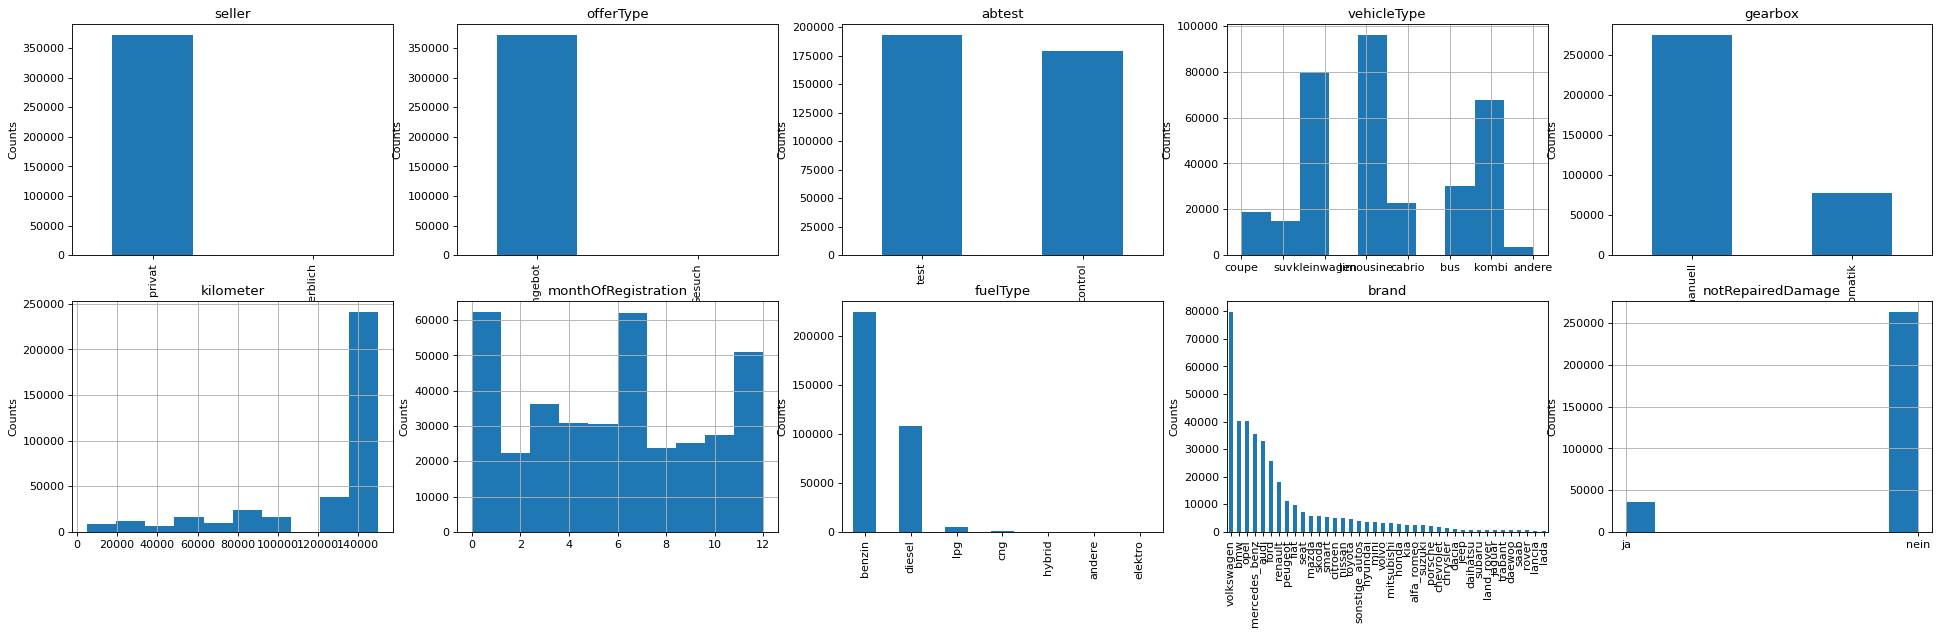

In [ ]:
barplotsColumns(autos,nLower = 1,nUpper = 100)

**2.Outliers Handling**

The presence of outliers may change the mean and standard deviation of the whole dataset. With tha beeing said, it is important to remove those outliers because presence of those outliers can mislead the model. 

Price

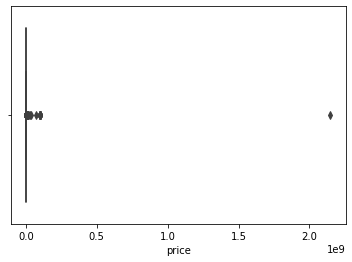

In [ ]:
sns.boxplot(x = autos['price'])

We can see that there are some outliers. Now, the goal is detect those outliers

In [ ]:
upper, lower = outliers(autos, "price",4)
lower  = 0.1 #set it manually since prices should be strictly positive.
print("Upper limit: ", upper)
print("Lower limit: ", lower)

Upper limit:  14369110.119507182
Lower limit:  0.1


In [ ]:
autos[(autos['price'] < lower) | (autos['price'] > upper)].shape

(10798, 20)

In [ ]:
autos = autos[(autos['price'] >= lower) & (autos['price'] <= upper)]

yearOfRegistration

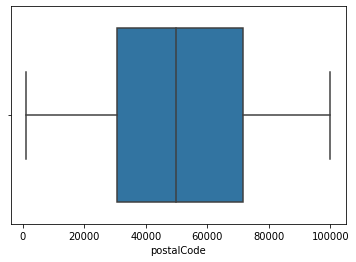

In [ ]:
sns.boxplot(x = autos['postalCode'])

From the above box plot, we can surely observe that there are no outliers in it





kilometer

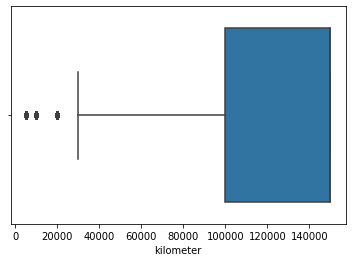

In [ ]:
sns.boxplot(x = autos['kilometer'])

From the above box plot, we can surely observe that there are outliers in it. However, they could be tolerated since it correspond to low mileage.





postalCode

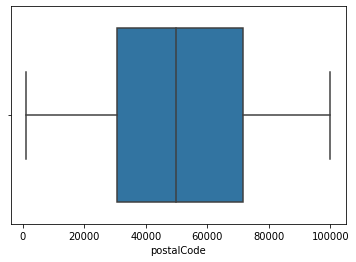

In [ ]:
sns.boxplot(x = autos['postalCode'])

powerPS

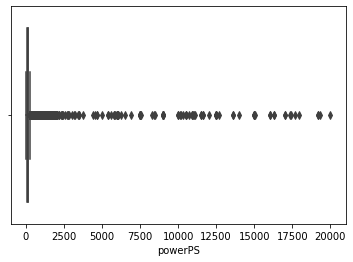

In [ ]:
sns.boxplot(x = autos['powerPS'])

In [ ]:
upper, lower = outliers(autos, "powerPS",4)
print("Upper limit: ", upper)
print("Lower limit: ", lower)

Upper limit:  879.0065599637073
Lower limit:  -645.8563589823639


In [ ]:
lower = 0
autos = autos[(autos['powerPS'] >= lower) & (autos['powerPS'] <= upper)]

In [ ]:
autos = autos.reset_index(drop=True)

In [ ]:
prices = autos.price
features = autos.drop('price',axis=1)

**3.Feature Engineering**

Extracted date related features

In [ ]:
date_columns = ['dateCreated','dateCrawled','lastSeen']

In [ ]:
for date_column in date_columns:
  features[date_column] = pd.to_datetime(features[date_column], format = '%Y-%m' ,errors = 'coerce')
  features['{}_year'.format(date_column)] = features[date_column].dt.year
  features['{}_month'.format(date_column)] = features[date_column].dt.month
  features = features.drop(date_column, axis=1)

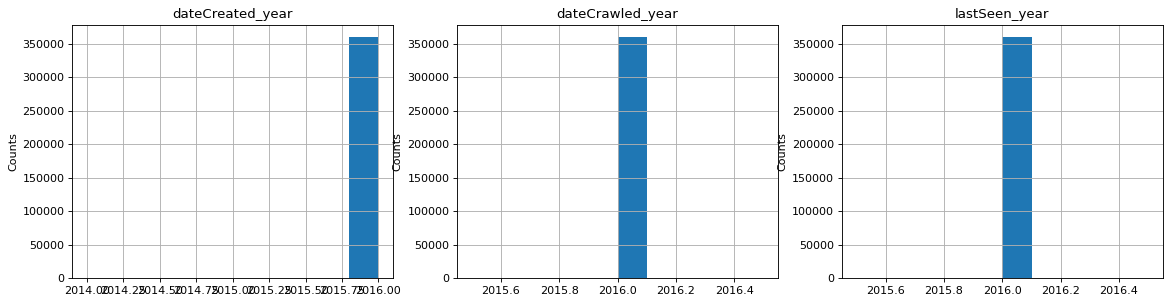

In [ ]:
barplotsColumns(features[['{}_year'.format(date_column) for date_column in date_columns]],nLower = 0,nUpper = 100)

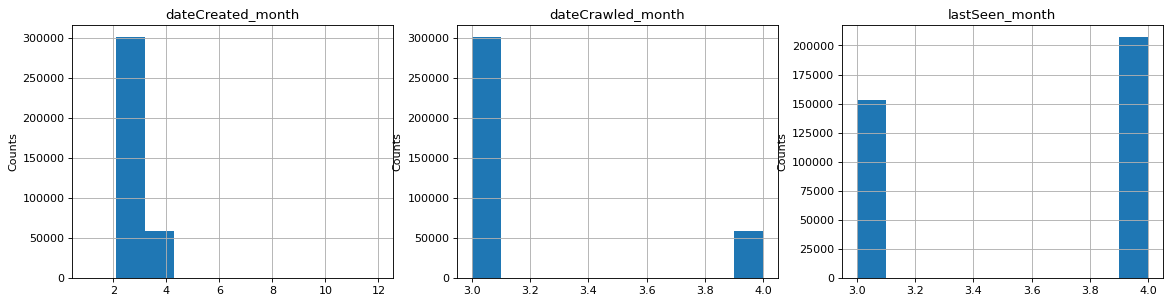

In [ ]:
barplotsColumns(features[['{}_month'.format(date_column) for date_column in date_columns]],nLower = 0,nUpper = 100)

In [ ]:
Eng_date_features_years = ['{}_year'.format(date_column) for date_column in date_columns ]
Eng_date_features_months = ['{}_month'.format(date_column) for date_column in date_columns ]

In [ ]:
features[Eng_date_features_years+Eng_date_features_months].describe()

,dateCreated_year,dateCrawled_year,lastSeen_year,dateCreated_month,dateCrawled_month,lastSeen_month
count,360412.000000,360412.0,360412.0,360412.000000,360412.000000,360412.000000
mean,2015.999914,2016.0,2016.0,3.161013,3.163210,3.576085
std,0.009568,0.0,0.0,0.377759,0.369558,0.494178
min,2014.000000,2016.0,2016.0,1.000000,3.000000,3.000000
25%,2016.000000,2016.0,2016.0,3.000000,3.000000,3.000000
50%,2016.000000,2016.0,2016.0,3.000000,3.000000,4.000000
75%,2016.000000,2016.0,2016.0,3.000000,3.000000,4.000000
max,2016.000000,2016.0,2016.0,12.000000,4.000000,4.000000


In [ ]:
features = features.drop(['dateCrawled_year','lastSeen_year'], axis=1)

In [ ]:
features.head(4)

,name,seller,offerType,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,nrOfPictures,postalCode,dateCreated_year,dateCreated_month,dateCrawled_month,lastSeen_month
0,Golf_3_1.6,privat,Angebot,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,0,70435,2016,3,3,4
1,A5_Sportback_2.7_Tdi,privat,Angebot,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,0,66954,2016,3,3,4
2,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,0,90480,2016,3,3,4
3,GOLF_4_1_4__3TÜRER,privat,Angebot,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,0,91074,2016,3,3,3


In [ ]:
#categorial and numerical Features
numeric_features = features.select_dtypes(include=[np.number]).columns
categorical_features = features.select_dtypes(exclude=[np.number]).columns

In [ ]:
numeric_features

Index(['yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration',
       'nrOfPictures', 'postalCode', 'dateCreated_year', 'dateCreated_month',
       'dateCrawled_month', 'lastSeen_month'],
      dtype='object')

In [ ]:
categorical_features

Index(['name', 'seller', 'offerType', 'abtest', 'vehicleType', 'gearbox',
       'model', 'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

**4.Handeling missing values**

In [ ]:
df_nan_model = autos[['name','model']]
df_nan_model

,name,model
0,Golf_3_1.6,golf
1,A5_Sportback_2.7_Tdi,NaN
2,"Jeep_Grand_Cherokee_""Overland""",grand
3,GOLF_4_1_4__3TÜRER,golf
4,Skoda_Fabia_1.4_TDI_PD_Classic,fabia
...,...,...
360407,Suche_t4___vito_ab_6_sitze,NaN
360408,Smart_smart_leistungssteigerung_100ps,fortwo
360409,Volkswagen_Multivan_T4_TDI_7DC_UY2,transporter
360410,VW_Golf_Kombi_1_9l_TDI,golf


The idea here is, for missing model values, to extract the model from the name field. In fact, almost all name fileds begins with the model name

In [ ]:
features.loc[df_nan_model[df_nan_model['model'].isna()].index,'model'] = df_nan_model[df_nan_model['model'].isna()]['name'].map(lambda x : x.split('_')[0]).values

In [ ]:
features.loc[df_nan_model[df_nan_model['model'].isna()].index,['name','model']]

,name,model
1,A5_Sportback_2.7_Tdi,A5
58,TAUSCHE_BMW_E38_740i_g._SUV_/_GELÄNDEWAGEN_LES...,TAUSCHE
81,Bastler_Fahrzeug_mit_Rest_Tuev,Bastler
135,Audi_80_5_Zylinder_b4_liebhaberfahrzeug,Audi
152,POLO_1.2_KILIMA_WIE_NEU,POLO
...,...,...
360287,Fiat_Stilo_Abarth_2.4_5zylinder_Seelespeed,Fiat
360361,ALPINA_D3_Touring,ALPINA
360380,Opel_Tigra,Opel
360394,LT_35_DIESEL_Gruene_Plakette....letzte_Gelegen...,LT


In [ ]:
#list of columns with missing value and its percentage
print(features.columns[features.isnull().any()])
nulls = pd.DataFrame(features.isnull().sum().apply(lambda x: round(100*x/len(features),3)).sort_values(ascending=False))
nulls.columns = ['Null Percentage']
nulls.index.name = 'Feature'
nulls

Index(['vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage'], dtype='object')


,Null Percentage
Feature,
notRepairedDamage,18.491
vehicleType,9.454
fuelType,8.289
gearbox,4.911
lastSeen_month,0.000
model,0.000
seller,0.000
offerType,0.000
abtest,0.000


Obviously, features with missing values are all categorical features.

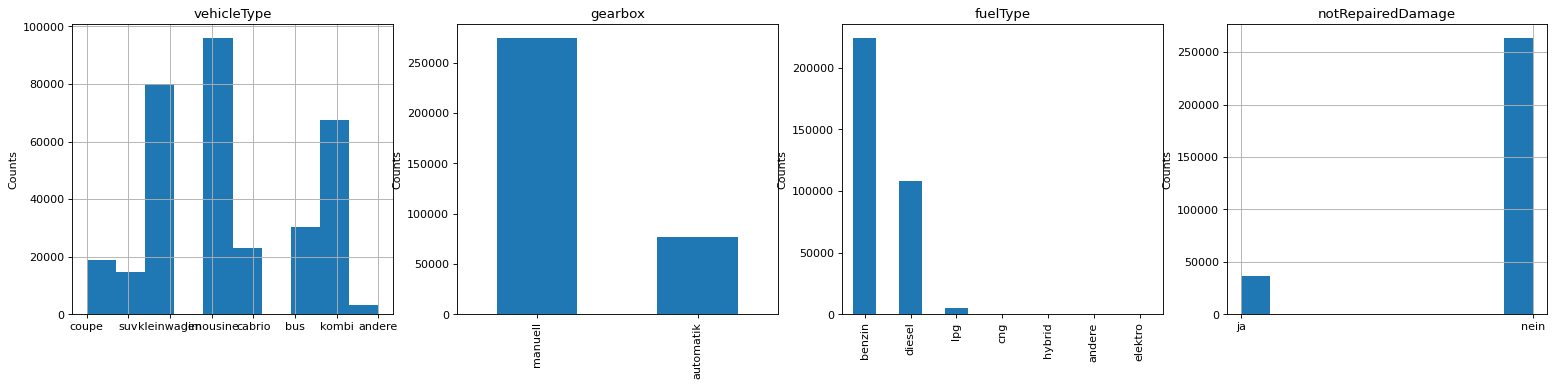

In [ ]:
features_Nan = features[features.columns[features.isnull().any()]]
barplotsColumns(features_Nan,nLower = 1,nUpper = features_Nan.nunique().max()+1)

In [ ]:
nan_col = features.columns[features.isnull().any()]
nan_col

Index(['vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage'], dtype='object')

Impute the remaining missing values with the most frequent value.

In [ ]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(features[nan_col])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [ ]:
imp_mean.transform(features[nan_col])
filling_features = pd.DataFrame(imp_mean.transform(features[nan_col]))
filling_features.columns = features[nan_col].columns
features[nan_col] = filling_features

In [ ]:
features.head(3)

,name,seller,offerType,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,nrOfPictures,postalCode,dateCreated_year,dateCreated_month,dateCrawled_month,lastSeen_month
0,Golf_3_1.6,privat,Angebot,test,limousine,1993,manuell,0,golf,150000,0,benzin,volkswagen,nein,0,70435,2016,3,3,4
1,A5_Sportback_2.7_Tdi,privat,Angebot,test,coupe,2011,manuell,190,A5,125000,5,diesel,audi,ja,0,66954,2016,3,3,4
2,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,nein,0,90480,2016,3,3,4


In [ ]:
names, sellers, offerTypes, abtests, vehicleTypes, gearboxs, models, fuelTypes, brands, notRepairedDamages = features.name, features.seller, features.offerType, features.abtest, features.vehicleType, features.gearbox, features.model, features.fuelType, features.brand, features.notRepairedDamage

**5.   Feature selection** : Removing both constant and quasi-constant features

In [ ]:
# import ordinal encoder from sklearn
ord_enc = OrdinalEncoder()
# Transform the data
features[categorical_features] = ord_enc.fit_transform(features[categorical_features])

In [ ]:
var_thr = VarianceThreshold(threshold = 0.1) 
var_thr.fit(features)
var_thr.get_support()

array([ True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True, False,  True,
        True,  True])

seller / offretype / dateCreated_year / nrOfPictures / notRepairedDamage

In [ ]:
features = features[list(features.columns[var_thr.get_support()])]

In [ ]:
features.head(3)

,name,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,postalCode,dateCreated_month,dateCrawled_month,lastSeen_month
0,76560.0,1.0,6.0,1993,1.0,0,1631.0,150000,0,1.0,38.0,70435,3,3,4
1,3884.0,1.0,3.0,2011,1.0,190,223.0,125000,5,3.0,1.0,66954,3,3,4
2,87361.0,1.0,7.0,2004,0.0,163,1632.0,125000,8,3.0,14.0,90480,3,3,4


**5.Bivariate Analysis**

In [ ]:
mapping_vehicleType = {k:v for v,k in zip(vehicleTypes,features.vehicleType)}
mapping_gearbox = {k:v for v,k in zip(gearboxs,features.gearbox)}
mapping_fuelType = {k:v for v,k in zip(fuelTypes,features.fuelType)}

In [ ]:
feature_BA = features.copy()
feature_BA.vehicleType = feature_BA.vehicleType.map(mapping_vehicleType)
feature_BA.gearbox = feature_BA.gearbox.map(mapping_gearbox)
feature_BA.fuelType = feature_BA.fuelType.map(mapping_fuelType)
feature_BA['price'] = prices

In [ ]:
feature_BA.shape

(360412, 16)

In [ ]:
sns.set(rc={"figure.figsize":(12, 4)}) 

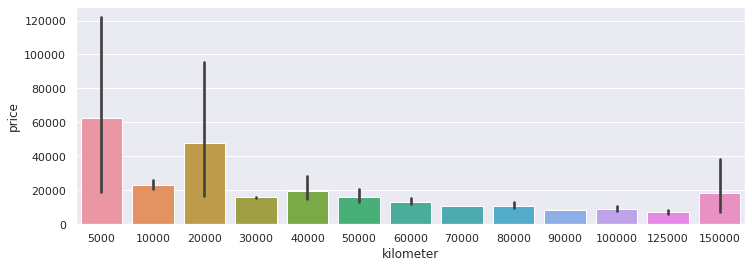

In [ ]:
sns.barplot(y="price", x="kilometer", data=feature_BA)

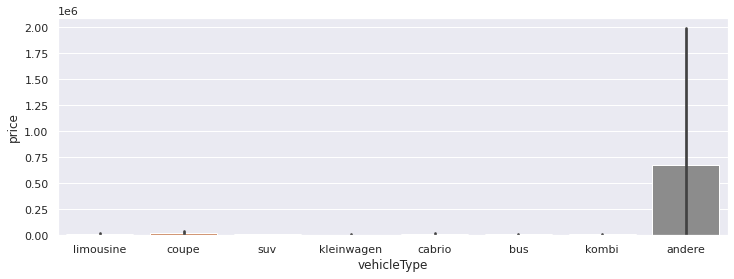

In [ ]:
sns.barplot(y="price", x="vehicleType", data=feature_BA)

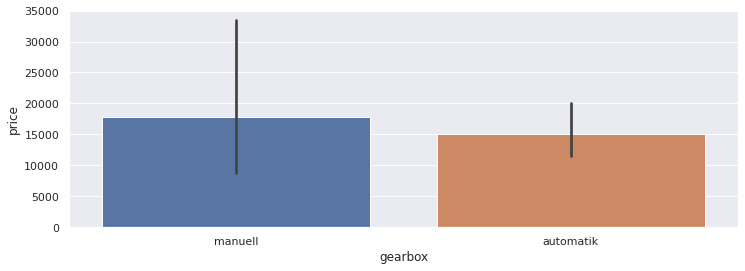

In [ ]:
sns.barplot(y="price", x="gearbox", data=feature_BA)

## **II - Modeling**

In [ ]:
cols = ['name', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType',
       'brand', 'postalCode', 'dateCreated_month', 'dateCrawled_month',
       'lastSeen_month']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features[cols], prices.loc[features.index], test_size=0.33, random_state=1)

**1.Linear regression**

Check if conditions for using Linear Regression are met. For this Purpose, the Correlation between every Variables(Features) must be low

In [ ]:
feature_BA = features.copy()
feature_BA['price'] = prices

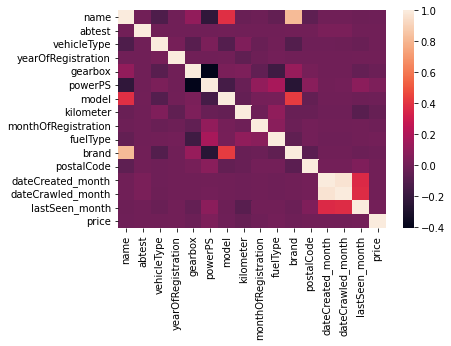

In [ ]:
corr=feature_BA.corr()
sns.heatmap(corr)
plt.show()

check if conditions for using Linear Regression are met. For this Purpose,Variables should have linear Relations


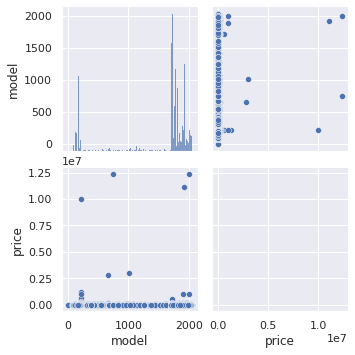

In [ ]:
sns.pairplot(feature_BA.head(50000), vars=["model","price"])
plt.show()
#Not necessarily the case

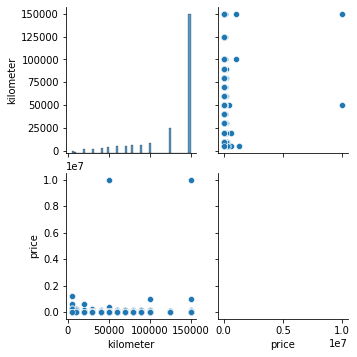

In [ ]:
sns.pairplot(feature_BA.head(50000), vars=["kilometer","price"])
plt.show()

In [ ]:
# fit multiple polynomial features
degrees = [1, 2]

y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

In [ ]:
for i, degree in enumerate(degrees):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)

In [ ]:
X_train.shape,y_train.shape

((241476, 15), (241476,))

In [ ]:
for i, degree in enumerate(degrees):
    train_r2 = sklearn.metrics.r2_score(y_train, y_train_pred[:, i])
    train_mse = mean_squared_error(y_train, y_train_pred[:, i])
    train_rmse = sqrt(train_mse)

    test_r2 = sklearn.metrics.r2_score(y_test, y_test_pred[:, i])
    test_mse = mean_squared_error(y_test, y_test_pred[:, i])
    test_rmse = sqrt(test_mse)
    print("Polynomial degree {}: train R2={}, train MSE={}, train RMSE={}, test R2={}".format(degree, 
                                                                                            train_r2,
                                                                                            train_mse, 
                                                                                            train_rmse,
                                                                                            test_r2,
                                                                                            test_mse,
                                                                                            test_rmse,
                                                                                            
                                                                                            ))

Polynomial degree 1: train R2=0.003717579870754939, train MSE=10879355995.222363, train RMSE=104304.15138057718, test R2=0.0023180067412836847
Polynomial degree 2: train R2=0.008164438830130516, train MSE=10830796509.777145, train RMSE=104071.1127536222, test R2=0.003272071250708053


**2.Random Forest**

In [ ]:
# importing Libraries:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Regression Tree
DTR = DecisionTreeRegressor(max_depth=7,random_state=33).fit(X_train,y_train)
print('DecisionTreeRegressor Train Score is: ',DTR.score(X_train,y_train))
predict_y=DTR.predict(X_test)
print('DecisionTreeRegressor Test Score is: ',DTR.score(X_test,y_test))
print("MSE:",mean_squared_error(predict_y,y_test, multioutput='uniform_average'))
print("RMSE:",sqrt(mean_squared_error(predict_y,y_test, multioutput='uniform_average')))

DecisionTreeRegressor Train Score is:  0.21913068324957416
DecisionTreeRegressor Test Score is:  -0.16126596272649785
MSE: 14367119827.794443
RMSE: 119862.92098807888


In [ ]:
from sklearn.model_selection import cross_val_score
first_cv_scores = cross_val_score(DTR, X_train,y_train, cv=5, scoring='neg_mean_squared_error')
second_cv_scores = cross_val_score(DTR, X_train,y_train, cv=10, scoring='neg_mean_squared_error')
print('mean in first_cv_scores is {0:.2f} and in second_cv_scores is {1:.2f}'.format(np.mean
(first_cv_scores),
 np.mean
(second_cv_scores)))

mean in first_cv_scores is -14933867813.33 and in second_cv_scores is -14127045924.58


In [ ]:
#Random Forest
rfregressor = RandomForestRegressor(n_estimators=100,max_depth=11, random_state=33).fit(X_train,y_train)
predict_y = rfregressor.predict(X_test)
print('Random Forest Regressor Train Score is : ' , rfregressor.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , rfregressor.score(X_test,y_test))
print("MSE is:",mean_squared_error(predict_y,y_test, multioutput='uniform_average'))
print("RMSE:",sqrt(mean_squared_error(predict_y,y_test, multioutput='uniform_average')))

Random Forest Regressor Train Score is :  0.683562276101925
Random Forest Regressor Test Score is :  -0.09263745396924161
MSE is: 13518051620.711758
RMSE: 116267.15624247356


In [ ]:
first_cv_scores = cross_val_score(rfregressor, X_train,y_train, cv=5, scoring='neg_mean_squared_error')
second_cv_scores = cross_val_score(rfregressor, X_train,y_train, cv=10, scoring='neg_mean_squared_error')
print('mean in first_cv_scores is {0:.2f} and in second_cv_scores is {1:.2f}'.format(np.mean
(first_cv_scores),
 np.mean
(second_cv_scores)))

mean in first_cv_scores is -12314893857.03 and in second_cv_scores is -12258469521.49


**3.Xgboost (Extreme Gradient Boosting )**

In [ ]:
# XGBregressor = xgb.XGBRegressor().fit(X_train,y_train)
# predict_y = XGBregressor.predict(X_test)
print('XGBOOST Regressor Train Score is : ' , XGBregressor.score(X_train, y_train))
print('XGBOOST Regressor Test Score is : ' , XGBregressor.score(X_test,y_test))
print("MSE of XGBOOST is:",mean_squared_error(predict_y,y_test, multioutput='uniform_average'))
print("RMSE:",sqrt(mean_squared_error(predict_y,y_test, multioutput='uniform_average')))

XGBOOST Regressor Train Score is :  0.18740832383118766
XGBOOST Regressor Test Score is :  -0.02797672541141583
MSE of XGBOOST is: 12718072576.151083
RMSE: 112774.43228033153


In [ ]:
first_cv_scores = cross_val_score(XGBregressor, X_train,y_train, cv=5, scoring='neg_mean_squared_error')
second_cv_scores = cross_val_score(XGBregressor, X_train,y_train, cv=10, scoring='neg_mean_squared_error')
print('mean in first_cv_scores is {0:.2f} and in second_cv_scores is {1:.2f}'.format(np.mean
(first_cv_scores),
 np.mean
(second_cv_scores)))

[23:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:46:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:47:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:47:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

As you can see, the models perform well on the train set. On the other hand, a worse perforamnce occured on the test set (negative R square score : worse than the best constant predictor). This invites us to reconsider the data at our disposal as the model seems to overfit: validated through cross validations.

In fact, our database presnts a large amount of data. Which is quite good for the learning process. In other words, not only more training data is always a good thing but also it is a way of counteracting overfitting. **Which is not the case here**. <font color='red'>The only way more data harms the models perforamnce is if the extra data is biased so the model will learn those biases. This is not due to excessive amounts of training data, though instead, it’s caused by bad data.</font>

That invites us to reproduce the above pipeline while minimizing the data noise sources. That would be through:

1. Get rid of rows with Nan values
2. Squeeze the outiers tolerance intervalle

In [ ]:
def get_rid_outliers(df, variable,scale):
    upper_limit, lower_limit = outliers(df, variable,scale)
    return df[(df[variable] >= lower_limit) & (df[variable] <= upper_limit)]

In [ ]:
autos = pd.read_csv(path + 'autos.csv',encoding='latin-1')
autos.shape

(371528, 20)

In [ ]:
autos = autos.dropna()
autos.shape

(260956, 20)

In [ ]:
autos = get_rid_outliers(autos, 'price',1)
autos = get_rid_outliers(autos, 'yearOfRegistration',1)
autos = get_rid_outliers(autos, 'powerPS',1)
autos = get_rid_outliers(autos, 'kilometer',1)
autos = get_rid_outliers(autos, 'yearOfRegistration',1)

In [ ]:
autos.shape

(91898, 20)

In [ ]:
prices = autos.price
features = autos.drop('price',axis=1)

In [ ]:
date_columns = ['dateCreated','dateCrawled','lastSeen']
for date_column in date_columns:
  features[date_column] = pd.to_datetime(features[date_column], format = '%Y-%m' ,errors = 'coerce')
  features['{}_year'.format(date_column)] = features[date_column].dt.year
  features['{}_month'.format(date_column)] = features[date_column].dt.month
  features = features.drop(date_column, axis=1)
features = features.drop(['dateCrawled_year','lastSeen_year'], axis=1)

In [ ]:
numeric_features = features.select_dtypes(include=[np.number]).columns
categorical_features = features.select_dtypes(exclude=[np.number]).columns

In [ ]:
ord_enc = OrdinalEncoder()
features[categorical_features] = ord_enc.fit_transform(features[categorical_features])
var_thr = VarianceThreshold(threshold = 0.1) #Removing both constant and quasi-constant
var_thr.fit(features)
var_thr.get_support()
features = features[list(features.columns[var_thr.get_support()])]

In [ ]:
cols = ['name', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType',
       'brand', 'postalCode', 'dateCreated_month', 'dateCrawled_month',
       'lastSeen_month']
X_train, X_test, y_train, y_test = train_test_split(features[cols], prices.loc[features.index], test_size=0.33, random_state=1)

In [ ]:
degrees = [1, 2]

y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))
for i, degree in enumerate(degrees):
  model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
  model.fit(X_train, y_train)
  # predict on test and train data
  # store the predictions of each degree in the corresponding column
  y_train_pred[:, i] = model.predict(X_train)
  y_test_pred[:, i] = model.predict(X_test)

for i, degree in enumerate(degrees):
    train_r2 = sklearn.metrics.r2_score(y_train, y_train_pred[:, i])
    train_mse = mean_squared_error(y_train, y_train_pred[:, i])
    train_rmse = sqrt(train_mse)

    test_r2 = sklearn.metrics.r2_score(y_test, y_test_pred[:, i])
    test_mse = mean_squared_error(y_test, y_test_pred[:, i])
    test_rmse = sqrt(test_mse)
    print("Polynomial degree {}: train R2={}, train MSE={}, train RMSE={}, test R2={}".format(degree, 
                                                                                            train_r2,
                                                                                            train_mse, 
                                                                                            train_rmse,
                                                                                            test_r2,
                                                                                            test_mse,
                                                                                            test_rmse,
                                                                                            
                                                                                            

Polynomial degree 1: train R2=0.4524763716980925, train MSE=5441199.498907566, train RMSE=2332.6378842219738, test R2=0.49798187210039435
Polynomial degree 2: train R2=0.5604640358925275, train MSE=4368035.905721114, train RMSE=2089.984666384209, test R2=0.6169084021022346


In [ ]:
DTR = DecisionTreeRegressor(max_depth=7,random_state=33).fit(X_train,y_train)
print('DecisionTreeRegressor Train Score is: ',DTR.score(X_train,y_train))
predict_y=DTR.predict(X_test)
print('DecisionTreeRegressor Test Score is: ',DTR.score(X_test,y_test))
print("MSE:",mean_squared_error(predict_y,y_test, multioutput='uniform_average'))
print("RMSE:",sqrt(mean_squared_error(predict_y,y_test, multioutput='uniform_average')))

DecisionTreeRegressor Train Score is:  0.6533403089079732
DecisionTreeRegressor Test Score is:  0.36576880252158617
MSE: 5508409.982261824
RMSE: 2347.0002092590075


In [ ]:
rfregressor = RandomForestRegressor().fit(X_train,y_train)
predict_y = rfregressor.predict(X_test)
print('Random Forest Regressor Train Score is : ' , rfregressor.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , rfregressor.score(X_test,y_test))
print("MSE is:",mean_squared_error(predict_y,y_test, multioutput='uniform_average'))
print("RMSE:",sqrt(mean_squared_error(predict_y,y_test, multioutput='uniform_average')))

Random Forest Regressor Train Score is :  0.9583447988214956
Random Forest Regressor Test Score is :  0.6963994580953539
MSE is: 2636824.335189804
RMSE: 1623.830143577155


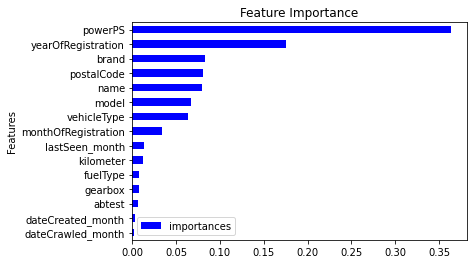

In [ ]:
df_imp = pd.DataFrame({'Features':features[cols].columns,'importances':rfregressor.feature_importances_})
df_imp.sort_values('importances',inplace=True)
df_imp.plot(kind='barh',y='importances',x='Features',color='b',title='Feature Importance')

The **powerPS**: the engine power is the most important feature of the Random Forest regressor. While the **year of regisration** and the **brand** came as second and third most important features. 

**lastSeen_months**, an engineered feature, is as important as the mileage and more important than fueltype and gearbow features.

In [ ]:
XGBregressor = xgb.XGBRegressor().fit(X_train,y_train)
predict_y = XGBregressor.predict(X_test)
print('XGBOOST Regressor Train Score is : ' , XGBregressor.score(X_train, y_train))
print('XGBOOST Regressor Test Score is : ' , XGBregressor.score(X_test,y_test))
print("MSE of XGBOOST is:",mean_squared_error(predict_y,y_test, multioutput='uniform_average'))
print("RMSE:",sqrt(mean_squared_error(predict_y,y_test, multioutput='uniform_average')))

[23:52:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBOOST Regressor Train Score is :  0.665242759985003
XGBOOST Regressor Test Score is :  0.721240880729069
Mean Squared Error of XGBOOST is: 2421072.191565872
RMSE: 1555.9794958693615


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold


Tuning the hyper-parameters with grid search : we are tuning the XGBOOST regressor model since it had the best performance on the test set

In [ ]:
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:  4.5min finished


0.7124356727412372
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [ ]:
XGBregressor_cv = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.05, max_depth= 6, min_child_weight= 4, n_estimators= 500, nthread= 4, objective= 'reg:linear', silent= 1, subsample= 0.7).fit(X_train,y_train)
predict_y = XGBregressor_cv.predict(X_test)
print('XGBOOST Regressor Train Score is : ' , XGBregressor_cv.score(X_train, y_train))
print('XGBOOST Regressor Test Score is : ' , XGBregressor_cv.score(X_test,y_test))
print("MSE of XGBOOST is:",mean_squared_error(predict_y,y_test, multioutput='uniform_average'))
print("RMSE:",sqrt(mean_squared_error(predict_y,y_test, multioutput='uniform_average')))


XGBOOST Regressor Train Score is :  0.828188750968209
XGBOOST Regressor Test Score is :  0.7767374114487346
MSE of XGBOOST is: 1939075.0192216174
RMSE: 1392.5067393810407


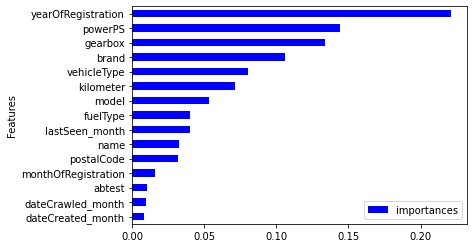

In [ ]:
df_imp = pd.DataFrame({'Features':features[cols].columns,'importances':XGBregressor1.feature_importances_})
df_imp.sort_values('importances',inplace=True)
df_imp.plot(kind='barh',y='importances',x='Features',color='b')

Compared to the Random forest regressor, the **year of registration** feature comes as the most important variable when predicting the price while **powerPS** and the **gearbox** features are second and third. Similary, **lastSeen_months** was quite important for the model in the regression task.

## **III - Interpretabilty with SHAP**

To understand why the model had such feature importances calculated, shap values come as an interpretability tool thanks to which we have the opportunity to get into the black box and see in detail why the model had such decisions.

In [ ]:
! pip install shap

     |████████████████████████████████| 371 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509238 sha256=f06c5148a892ac308dea1ca6554690f2070cccfc9b510decd36f8de726af8bfb
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
import shap

In [ ]:
shap_values = shap.TreeExplainer(XGBregressor_cv).shap_values(X_test)

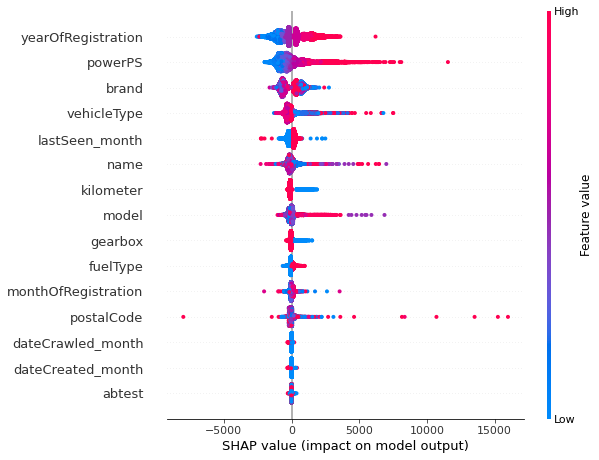

In [ ]:
shap.summary_plot(shap_values, X_test)

For each feature a distribution is plotted on how the train samples influence the model outcome. The more red the dots, the higher the feature value, the more blue the lower the feature value. On the other hand, the more the dots get in the positive mi-space the higher its impact on increasing the price and vice versa.

For instance, the higher the year of registration gets ( red color) the higher the price gets ( positive impact) which is quite inuitive. The same scenario for the PowerPS feature.
On the contrary, the less the mileage gets (blue color) the higher the price gets.

As you can notice through those examples, the model had very intuitive decision based on the above features. Apart from that, having a high R2 score on the test set (0.77) proves that the XGBoost model generalizes well his decesion rule on foorseein gthe price.

We can also look at a single datapoint and identify how a single datapoint was predicted using a decision plot. In this example that corresponds to a Limousine, the model predicted a high price value mainly due to a large deviation in model, PewerPS and the Brand.

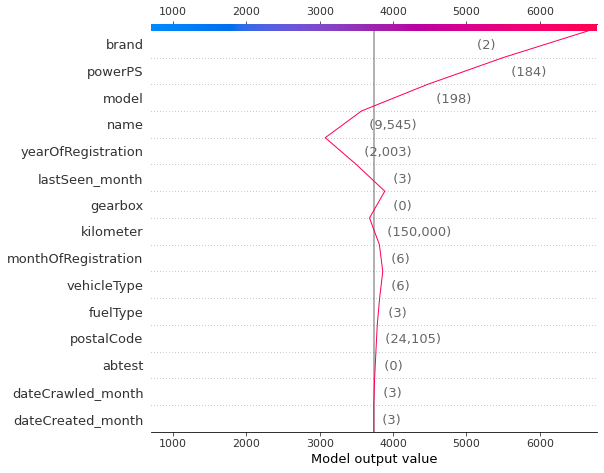

limousine


In [ ]:
i = 6
X_test_ = X_test.to_numpy()
shap.decision_plot(shap.TreeExplainer(XGBregressor1).expected_value, shap_values[i], X_test_[i], feature_names = list(X_test.columns))
print(mapping_vehicleType[X_test.iloc[i]['vehicleType']])